# コア

> SCMOPTは様々なシステム（モジュール）を有機的に結合したものである．ここでは，様々なモジュールで使用する共通部品を定義する．


In [ ]:
#| default_exp core

In [ ]:
#| export
from typing import List, Optional, Union, Tuple, Dict, Set, Any, DefaultDict
from pydantic import BaseModel, Field, ValidationError, validator, confloat, conint, constr, Json
from pydantic.tools import parse_obj_as
from datetime import datetime, date, time

import random
import datetime as dt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from collections import defaultdict, OrderedDict, Counter
import requests

folder = "./data/"
host = "test-osrm-intel.aq-cloud.com"
mapbox_access_token = 'pk.eyJ1IjoibWlraW9rdWJvIiwiYSI6ImNqYXQ3dHBqdzR5ZGwyd3BkeG5rOTl0b2UifQ.1utsXNi2V-WdzfWlvCMj_A'

## グラフクラス SCMGraph

> サプライ・チェインのためのグラフクラス

SCMGraphクラスは，networkXの有向グラフクラスDiGraphから派生したものであり，以下のメソッドが追加されている．

- random_directed_tree(n=1, seed=None): ランダムな有向木を生成する．引数は点数n（既定値1）と擬似乱数の種seed（既定値None）.
- layered_network(num_in_layer=None, p=0.5, seed=None): ランダムな層型の有向グラフを生成する． 引数num_in_layerは，各層内の点数を入れたリストで既定値は[1,1]，ｐは枝の発生確率で既定値は0.5，seedは擬似乱数の種である．
- layout(): 有向グラフを描画する際の座標を返す関数．返値は点の名称をキーとし，点のx,y座標を値とした辞書．
- down_order(): 閉路を含まない有向グラフに対して，供給地点側から需要地点側の順番で点を返すジェネレータ関数．
- up_order(): 閉路を含まない有向グラフに対して，需要地点側から供給地点側の順番で点を返すジェネレータ関数．
- dp_order(): 有向木に対して，葉から順番に点を生成するジェネレータ関数． 安全在庫配置問題に対する動的最適化で用いる．
- bfs(start): 点startを開始点として，広がり優先探索で点を生成するジェネレータ関数．
- find_ancestors(): 各点から到達可能な点の集合（自分自身を含む）を保持するリスト．点の順序はup_orderとする．


In [ ]:
#| export
class SCMGraph(nx.DiGraph):
    '''
     SCMGraph is a class of directed graph with edge weight that can be any object.
     I just use the functions such as in_degree, out_degree, successors,
     predecessors, in_edges_iter, out_edges_iter.
     So it is convertible to any graph class that can access the adjacent nodes more quickly.
    '''

    def random_directed_tree(self, n=1, seed=None):
        """
        generate random directed tree
        """
        random.seed(seed)
        G = nx.generators.trees.random_tree(n=n, seed=seed)
        #print("seed=",seed)
        self.add_nodes_from(G)
        for (u, v) in G.edges():
            if random.random() <= 0.5:
                self.add_edge(u, v)
            else:
                self.add_edge(v, u)

    def layered_network(self, num_in_layer=None, p=0.5, seed=None):
        '''
          Input the number of nodes in layers as a list like NumInLayer=[4,5,6,7]
          and the probability with which edge occures,
          return a layered and connected directed graph
        '''

        random.seed(seed)
        if num_in_layer is None:
            num_in_layer = [1, 1]
        else:
            num_in_layer = list(num_in_layer)
        Layer = []
        startID = 0
        layerID = {}
        numlayer = 0
        for l in num_in_layer:
            endID = startID+l
            Layer.append((range(startID, endID)))  # append to the layer
            for i in range(startID, endID):
                layerID[i] = numlayer  # store the layer index of the node
            numlayer += 1
            startID = endID
        n = endID
        self.add_nodes_from(range(n))
        for l in range(len(Layer)-1):
            for i in Layer[l]:
                for j in Layer[l+1]:
                    if random.random() <= p:  # add an edge w.p. "p"
                        self.add_edge(i, j)

    def layout(self):
        '''
        Compute x,y coordinates for the supply chain
           The algorithm is based on a simplified version of Sugiyama's method.
           First assign each node to the (minimum number of) layers;
           Then compute the y coordinate by computing the means of y-values
           of adjacent nodes
           return the dictionary of (x,y) positions of the nodes
        '''
        longest_path = nx.dag_longest_path(self)
        LayerLB = {}
        pos = {}
        MaxLayer = len(longest_path)
        candidate = set([i for i in self]) - set(longest_path)
        #print(longest_path)
        for i in candidate:
            LayerLB[i] = 0

        Layer = defaultdict(list)
        for i, v in enumerate(longest_path):
            Layer[i] = [v]
            LayerLB[v] = i
            for w in self.successors(v):
                if w in candidate:
                    LayerLB[w] = LayerLB[v]+1

        L = list(nx.topological_sort(self))

        for v in L:
            if v in candidate:
                #print(v,end=" ")
                Layer[LayerLB[v]].append(v)
                candidate.remove(v)
                for w in self.successors(v):
                    if w in candidate:
                        LayerLB[w] = max(LayerLB[v]+1, LayerLB[w])

        MaxLayer = len(Layer)
        for i in range(MaxLayer+1):
            if i == 0:
                j = 0
                for v in Layer[i]:
                    pos[v] = (i, j)
                    j += 1
            else:
                tmplist = []
                for v in Layer[i]:
                    sumy = 0.0
                    j = 0.0
                    for w in self.predecessors(v):
                        (ii, jj) = pos[w]
                        sumy += jj
                        j += 1.0
                    if j != 0:
                        temp = sumy/j
                    else:
                        temp = j
                    tmplist.append((temp, v))
                tmplist.sort()
                order = [v for (_, v) in tmplist]
                j = 0
                for v in Layer[i]:
                    pos[order[j]] = (i, j)
                    j += 1
        return pos

    def down_order(self):
        '''
        generator fuction in topological order
        generate the order of nodes from suppliers to demand points
        '''
        degree0 = []
        degree = {}
        for v in self:
            if self.in_degree(v) == 0:
                degree0.append(v)
            else:
                degree[v] = self.in_degree(v)
        # print degree0
        while degree0:
            v = degree0.pop()
            # print v
            yield v
            for w in self.successors(v):
                degree[w] -= 1
                if degree[w] == 0:
                    degree0.append(w)

    def up_order(self):
        '''
        Generator fuction in the reverse topological order
        generate the order of nodes from to demand points to suppliers
        '''
        degree0 = []
        degree = {}
        for v in self:
            if self.out_degree(v) == 0:
                degree0.append(v)
            else:
                degree[v] = self.out_degree(v)
        while degree0:
            v = degree0.pop()
            yield v
           # print v
            for w in self.predecessors(v):
                degree[w] -= 1
                if degree[w] == 0:
                    degree0.append(w)

    def dp_order(self):
        '''
        Generater function for the safety stock allocation problem
        This function returns (yields) the leaf ordering sequence of nodes
        Remark: the graph must be tree! Otherwise, this function does not generate
        all the nodes.
        '''

        # check the underling graph is a tree or not
        is_tree = nx.is_tree(self)
        if is_tree == False:
            print("Graph is not a tree.")
            return

        Leaf = set([])
        Searched = set([])
        degree = {}
        for v in self:
            degree[v] = self.out_degree(v)+self.in_degree(v)
            if degree[v] <= 1:
                Leaf.add(v)

        while Leaf:
            v = Leaf.pop()
            # print v,Leaf
            yield v
            Searched.add(v)
            for w in set(self.successors(v)) | set(self.predecessors(v)):
                # print "adj=",w
                if w not in Searched:
                    if degree[w] >= 2:
                        degree[w] -= 1
                    if degree[w] <= 1:
                        Leaf.add(w)

    def bfs(self, start=None):
        '''
        breadth first search from a given node 'start'
        '''
        if start is None:
            start = list(self.nodes)[0]
        L = []
        L.append(start)  # L is the list that keeps the active (front) nodes
        # Searched is the set that includes all the nodes searched so far
        Searched = set([start])
        while L:
            v = L.pop(0)  # extract the first element in the list
            # print v," is searched"
            yield v
            for w in self.successors(v):
                if w not in Searched:
                    L.append(w)
                    Searched.add(w)
                    # print "L=",L,Searched
                else:
                    print(f"arc ({v}, {w}) makes a cycle")

    def find_ancestors(self):
        '''
        find the ancestors based on the BOM graph
        The set of ancestors of node i is the set of nodes that are reachable from node i (including i).
        '''
        ancestors = {v:set([]) for v in self}
        for v in self.up_order():
            ancestors[v] = ancestors[v] | set([v])
            for w in self.successors(v):
                ancestors[v] = ancestors[v] | ancestors[w]
        return ancestors

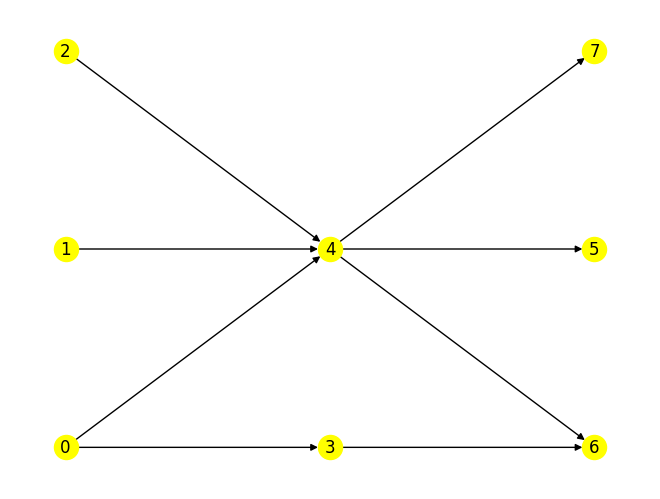

In [ ]:
%matplotlib inline 
G = SCMGraph()
G.layered_network(num_in_layer=[3, 2, 3], p=0.4, seed=123)
pos = G.layout()
nx.draw(G, pos=pos, with_labels=True, node_color="Yellow")

## 温室化ガス排出量

生産部門では，電力，蒸気に対して原単位が設定されている．

廃棄に対しても，物別に原単位が設定されている．

調達に対しては，調達費用に対して原単位が設定されている．

輸送部門：

|  輸送手段  |  $CO_2$ （gCO2/トンキロ）  |
| ---- | ---- |
|  鉄道  |  22  |
|  船舶  |  39  |
|  航空  |  1490  |

トラックに対しては，燃料使用量を以下の式で計算してから算出する．


- y：輸送トンキロ当たり燃料使用量（l）
- x：積載率（%）
- z：最大積載量（kg）


ガソリン車: ln y＝2.67－0.927 ln (x/100)－0.648 ln z
 
ディーゼル車: ln y＝2.71－0.812 ln (x/100)－0.654 ln z

ただし，積載率10％未満の場合は、積載率10％の時の値を用いる．なお、表記「ln」は自然対数（eを底とする対数）

$CO_2$排出量は，上で求めた燃料使用量に以下の値を乗じて計算する．

　単位発熱量(GJ/kl)×排出係数(tCO2/GJ) = 34.6 × 0.0183 = 2.322 (tCO2/kl) 
 

In [ ]:
#| export
def co2(capacity, rate = 0.5, diesel=False):
    """
    引数： 
       - capacity：積載重量（kg)
       - rate: 積載率 (0<rate<=1.0)
       - diesel: ディーゼル車の場合 True， ガソリン車の場合 False
    返値：
       - fuel: トンキロあたりの燃料使用量（リットル）
       - co2: CO2排出量(g)
    """
    if diesel:
        fuel = math.e**(2.67-0.927*math.log(rate) - 0.648*math.log(capacity))
    else:
        fuel = math.e**(2.71-0.812*math.log(rate) - 0.654*math.log(capacity))
    co2 = fuel*2.322*1000
    return fuel, co2

## 日付時刻もしくは時刻型の差を計算して，秒を返す関数 time_delta

引数：

- finish: 終了時刻を表す日付時刻型（もしくは時刻型）
- start: 開始時刻を表す日付時刻型（もしくは時刻型）

返り値：

- 時刻の差（秒）

In [ ]:
#| export
def time_delta(finish, start):
    """
    日付時刻もしくは時刻型の差を計算して，秒を返す関数
    """
    try: #datetime型
        return int((finish-start).total_seconds())
    except TypeError: #time型
        td = (dt.datetime.combine(dt.date(2000,1,1), finish) - dt.datetime.combine(dt.date(2000,1,1), start) )
        return td.days*60*60*24 + td.seconds
        #return (dt.datetime.combine(dt.date(2000,1,1), finish) - dt.datetime.combine(dt.date(2000,1,1), start) ).seconds

### time_deltaの使用例

In [ ]:
print( time_delta( dt.datetime(2020,1,2,10,0), dt.datetime(2020,1,1,0,0)) )
print( time_delta( dt.time(10,0), dt.time(11,0)) )
print( time_delta( dt.time(12,0), dt.time(6,0)) )

122400
-3600
21600


## 日付時刻（もしくは時刻）型に指定した時間（秒）を加えた時刻を返す関数 add_seconds

引数
- start: 開始時刻を表す日付時刻型（もしくは時刻型）
- seconds: 時間（秒）

返値：
- 指定した時間だけすすめた（日付）時刻


In [ ]:
#| export
def add_seconds(start, seconds):
    try:
        finish = start + dt.timedelta(seconds=seconds)
        return finish.strftime("%Y-%m-%d %H:%M")
    except TypeError:
        finish = (dt.datetime.combine(dt.date(2000,1,1), start) + dt.timedelta(seconds=seconds))
        return finish.strftime("%H:%M")

### add_secondsの使用例

In [ ]:
print( add_seconds( dt.datetime(2020,1,1,10,0), 1000) )
print( add_seconds( dt.time(10,0), 1000) )

2020-01-01 10:16
10:16


## 地点（顧客）間の距離と移動時間の計算関数 compute_durations

OSRMを必要とする．

引数：
- cust_df: 顧客データフレーム（名称と緯度・経度情報をもつデータフレーム）
- plnt_df: 工場データフレーム（オプション；既定値 None) 
- toll: 有料道路が使用可のときTrue（既定値 True)
- ferry: フェリーが使用可のときTrue（既定値 True) (TODO: OSRMの前処理時に，car.luaファイルを以下を修正する必要がある．）

```
excludable = Sequence {
        Set {'toll'},
        Set {'motorway'},
        Set {'ferry'}, 
        Set {'ferry', 'toll'})
    },
```

- host: ホスト名；既定値は "localhost"

返値：
- durations: 地点間の移動時間（計算に失敗した場合には大きな数字が入っている．）
- distances: 地点間の道路距離（計算に失敗した場合には大きな数字が入っている．）
- node_df: 点のデータフレーム（顧客もしくは顧客と工場を結合したもの）

In [ ]:
#| export
def compute_durations(cust_df, plnt_df=None, toll=True, host="localhost"):
    
    if plnt_df is not None:
        node_df = pd.concat( [cust_df[["name","lat","lon"]], plnt_df[["name","lat","lon"] ] ] )
    else:
        node_df = cust_df.copy()
    n=len(node_df)
    ROUTE =[]
    for row in node_df.itertuples():
        ROUTE.append( [row.lat, row.lon] )
    route_str =""
    for (i,j) in ROUTE[:]:
        route_str += str(j)+","+str(i)+";"
    #print(f"http://{host}:5000/table/v1/driving/'"+route_str[:-1]+"?annotations=distance,duration")
    #response = requests.get('http://localhost:5000/table/v1/driving/'+route_str[:-1]+"?annotations=distance,duration&exclude=motorway")
    if toll:
        response = requests.get(f'http://{host}:5000/table/v1/driving/'+route_str[:-1]+"?annotations=distance,duration")
    else:
        response = requests.get(f'http://{host}:5000/table/v1/driving/'+route_str[:-1]+"?annotations=distance,duration&exclude=toll")
    result = response.json()

    try:
        durations = result["durations"]
        distances = result["distances"]
    except:
        raise ValueError 
    for i in range(n):
        for j in range(n):
            if durations[i][j] is None:
                #print(i,j)
                durations[i][j] = 3600*24
                distances[i][j] = 1000000
    return  durations, distances, node_df

### compute_durations関数の使用例

In [ ]:
cust_df = pd.read_csv(folder+"cust.csv")
durations,  distances, node_df = compute_durations(cust_df, toll=False, host=host)
print(sum(durations[0]))

3730084.0


## 地点間の距離と移動時間のデータフレームを生成する関数 make_time_df

引数：
- node_df: 点のデータフレーム（顧客もしくは顧客と工場を結合したもの）
- durations: 地点間の移動時間（計算に失敗した場合には大きな数字が入っている．）
- distances: 地点間の道路距離（計算に失敗した場合には大きな数字が入っている．）

返値：
- time_df: 発地，着地，移動時間（秒），道路距離（m）を入れたデータフレーム

In [ ]:
#| export
def make_time_df(node_df, durations, distances):
    try:
        node_df.reset_index(inplace=True)
    except:
        pass
    
    n = len(durations)
    name_dic = node_df.name.to_dict() #番号を顧客名に写像
    from_id, to_id, duration, distance =[],[],[],[]
    from_name, to_name = [], [] 
    for i in range(n):
        for j in range(n):
            from_id.append(i)
            to_id.append(j)
            from_name.append(name_dic[i])
            to_name.append(name_dic[j])
            duration.append( int(durations[i][j]) )
            distance.append( int(distances[i][j]) )
    time_df = pd.DataFrame({"from_node": from_id, "from_name": from_name, "to_node":to_id, "to_name":to_name, "time": duration, "distance": distance })
    return time_df

###  make_time_df関数の使用例

In [ ]:
time_df =  make_time_df(node_df, durations, distances)
time_df.head()

,from_node,from_name,to_node,to_name,time,distance
0,0,札幌市,0,札幌市,0,0
1,0,札幌市,1,青森市,23883,425746
2,0,札幌市,2,盛岡市,28264,545192
3,0,札幌市,3,仙台市,38347,754593
4,0,札幌市,4,秋田市,31425,608789


## time_dfからdurationsとdistancesを生成する関数 make_durations

上で作成した time_df から，移動時間と移動距離を生成する．

引数：
- time_df: 移動時間と道路距離を保持するデータフレーム

返値：
- durations: 移動時間行列
- distances: 道路距離行列

In [ ]:
#| export
def make_durations(time_df):
    n = time_df.from_node.max() + 1
    durations = np.zeros((n,n))
    distances = np.zeros((n,n))
    for row in time_df.itertuples():
        durations[ int(row.from_node), int(row.to_node) ] = int(row.time)
        distances[ int(row.from_node), int(row.to_node) ] = int(row.distance)
    return durations, distances

### make_durations関数の使用例

In [ ]:
time_df = pd.read_csv(folder + "melos/time.csv")
durations, distances = make_durations(time_df)
distances

array([[      0.,  427015.,  546453., ..., 2247148., 2288685., 3080358.],
       [ 426987.,       0.,  183876., ..., 1815653., 1857189., 2648863.],
       [ 546501.,  183838.,       0., ..., 1736609., 1778145., 2569819.],
       ...,
       [2247483., 1814532., 1736893., ...,       0.,  132654.,  924327.],
       [2293427., 1860476., 1782837., ...,  134850.,       0.,  795782.],
       [3083057., 2650105., 2572466., ...,  924479.,  795964.,       0.]])